# Step 1: Setting up the environment

#### To create and activate a virtual environment, run on your terminal:

**Windows:**


```
python -m venv venv
```
```
venv\Scripts\Activate
```

**macOS/Linux:**

```
python3 -m venv venv
```

```
source venv/bin/activate
```

#### After the environment is activated, install the requirements:

```
pip install -r requirements.txt
```


# Step 2: Pre-processing the document

#### What you will need:
1. PDF Document (skin cancer detection paper in my case)
2. Embedding model (I am using Sentence-Bert)

As described in the Readme file, the aim of this tutorial is to build a RAG-assisted LLM that can retrieve information from research papers, helping students and researchers get a quicker understanding of the paper. I will be using the paper *Skin Cancer Detection using ML Techniques* <sup>1</sup> for this example.  Feel free to use any paper you would like to retrieve information from, the same steps will apply to any paper / book. All you need to do is download it in pdf format and add your file path to the variable 'path'.  

To pre-process the PDF document, we will use an embedding model. 

#### ⚠️ Now, what does “embedding” mean in AI?

In this tutorial, we are trying to get our AI model to understand a paper (complex text data). The problem is, our model can only understand numbers. That is where embeddings come in.

> An embedding is a way of representing complex data (like words or images) as a list of numbers — called a vector — in such a way that the relationships between items are preserved.


#### Let’s dive into that:

Think of each item (a word, an image, a sentence) as a point in space - a location on a map. The closer two points are, the more related their meanings are.

For example:

- The word “cat” will be close to “dog”.

- The word “car” will be far away from “banana”.

That’s because in real life, cats and dogs are similar (both animals, pets), while a car and a banana are not.

So embeddings help us map meaning into a mathematical space.

#### 🧐 What is an embedding model?

An embedding model is an AI model that has learned how to take something complex — like a sentence — and turn it into a vector (a list of numbers) that captures its meaning.

Different embedding models specialize in different kinds of data. The table below shows some examples of open-source embedding models for different use cases:


| Data Type         | Embedding model examples    | What do they capture? |
|-------------------|-----------------------------|-------------------------------
| Words | Word2Vec, GloVe, FastText | Word meanings, analogies, syntactic similarity |
| Sentences / Text | Sentence-BERT (SBERT), Instructor, E5 | Semantic similarity between sentences/documents |
| Images              |  DINO, OpenCLIP   | Visual concepts, cross-modal (image-text) meaning   |
| Audio               |  Wav2Vec 2.0, Whisper  | Speech content, audio features   |
| Code | CodeBERT, GraphCodeBERT | Code syntax and semantics |  

In this tutorial we are looking to read PDF documents, therefore, we need a model that embeds data based on semantic similarity. I have chosen Sentence-BERT, but it is interchangable for any sentence / text embedding model. Once you have build your own RAG-assisted LLM, you can experiment with different models and decide what works best for you

Note that embedding models do not exactly embed words or sentences, they embed tokens.

#### ❓ What is a token?

A token is a smallest unit of input that a language model (like GPT or BERT) understands.

In most modern NLP systems, tokens are not exactly words — they can be:

- A whole word (hello)

- A subword (un, believ, able)

- A punctuation mark (!, .)

- Even just a few characters (Th, is)

Think of a token as a "chunk" of text — a building block the model processes one at a time.

> **Example**
> 
> Sentence: "This is amazing!" might be tokenized as:
> 
> ['This', ' is', ' amazing', '!']


.
> Note that, on average in English text, 1 token is equal to 4 characters.


#### Now that we know how the data pre_processing will work, let's get started!




<sup>1</sup> M. Vidya and M.V. Karki "Skin Cancer Detection using Machine Learning Techniques", 2020 IEEE International Conference on Electronics, Computing and Communication Technologies, Bangalore, India, 2020, pp. 1-5, doi 10.1109/CONECCT50063.2020.9198489.98489. 








#### 2.1. Importing the relevant modules, getting the PDF we want to read, and extracting text from it:

In [1]:
# Import relevant modules
import fitz
import os
import requests
import re
from tqdm.auto import tqdm

# Get PDF path (change this variable to your pdf path)
#____________________________________________________________________
path = r"G:\My Drive\feines 2025\MS Imaging paper\to submit.pdf"
#____________________________________________________________________

# Check that the path exists
if os.path.exists(path):
    print(f"PDF file '{path}' exists.")
else:
    print(f"PDF file '{path}' does not exist")

# Open the PDF file
paper = fitz.open(path)
    
# Define a helper function to extract text from the pdf
def extract_text(paper: fitz.Document):
  """Applies formatting to the PDF textand stores the content in a list of dictionaries
  Inputs: 
      paper (fitz.Document): PDF document
  Outputs: 
      output (list[dict]): List of dictionaries containing the formatted extracted text from each PDF page 
      and the corresponding page number
  """

  # Define an empty list that will be filled with the extracted text
  output = []

  # CHANGE THIS LOOP A BIT MORE !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  for page_number, page in enumerate(paper):
    paper_text = page.get_text()
    paper_text = re.sub(r'\s+', ' ', paper_text).strip() # removes any \n or white spaces
    output.append({"page_number": page_number,       
                   "text": paper_text
                   })
  return output

# Check that the helper function works as expected by printing the first page
output = extract_text(paper=paper)
print(output[1])

G:\My Drive\feines 2025\Github\tutorial_RAG-assisted-LLM\venv_llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PDF file 'G:\My Drive\feines 2025\MS Imaging paper\to submit.pdf' exists.
{'page_number': 1, 'text': 'Various studies have proposed using smartphone cameras for MSI, mainly motivated by the biomedical optics community, with the aim of monitoring haemodynamics by detecting the different spectral characteristics of oxygenated and deoxygenated haemoglobin in blood. Some of these require modifications or additions to the smartphone [7–10] but a new approach by He and Wang [11,12] was able to derive simulated multispectral images from an unmodified smartphone camera. Here, we adapt the method of He and Wang and apply it to generating simulated multispectral images from digitised photographs of a palimpsest. The photographs were acquired using standard digitisation protocols so the method described here could be applied to any digitised images. The technique requires a colourchecker chart which is imaged using a multispectral imaging system and with standard photography. These images are pro

#### 2.2. Chunking the extracted text

First of all, we will the NLP library **SpaCy** to divide our extracted text in sentences.

This is due to the fact that embedding models cannot process an infinite number of tokens, therefore we need to limit the number of tokens by chunking the text into groups of sentences.

For this tutorial I have split the text in chunks of 15 sentences, although this number is arbitrary. Feel free to experiment and decide what works best with your model. What is the criteria to keep in mind:
1. Smaller groups of text will be easier to inspect, making it easier to filter content
2. The text chunks need to fit into our embedding model's context window
3. Chunks too large will make the context that will be passed to the LLM too vague
4. Chunks too short might leave out information that is also relevant / be misleading
5. We want to find a chunk size so that the context passed to the LLM will be specific and focused

# REVIEW CONTENT (siml) FROM HERE


In [2]:
from spacy.lang.en import English

spacy = English()

# Add a sentencizer pipeline (sentencizer turns text into sentences)
# You can check the documentation at https://spacy.io/api/sentencizer
spacy.add_pipe("sentencizer")

# Test that the sentencizer works
test_spacy = spacy("SpaCy is an NLP library. It splits text into sentences. Let's test it.")
assert len(list(test_spacy.sents)) == 3
print(list(test_spacy.sents))

# Define the number of sentences per chunk
len_chunks = 15

# Create a function to split the text into chunk size
def split_list(input_list: list[str],
               slice_size: int = len_chunks):
  """Splits text into chunk size"""
  return [input_list[i:(i + slice_size)] for i in range(0, len(input_list), (slice_size))] #CHANGE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  # Reminder: range(start, stop, step)

test_list = list(range(25))
split_list(test_list)


[SpaCy is an NLP library., It splits text into sentences., Let's test it.]


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]

In [3]:
# Loop through pages and split the text into sentences
for item in tqdm(output):
  # Get a list of sentences in the current item's text:
  item["sentences"] = list(spacy(item["text"]).sents)
  # Make sure all sentences are strings:
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]
  # Loop through pages and split sentences into chunks, then get number of sentences per chunk:
  item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                       slice_size=len_chunks)
  item["num_chunks"] = len(item["sentence_chunks"])
  # Count the sentences:
  item["page_sentence_count_spacy"] = len(item["sentences"])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 83.64it/s]


In [4]:
import random
random.sample(output, k=1)

[{'page_number': 12,
  'text': 'the information available in a full MSI dataset and are generally less helpful for analysis. Despite this, in some instances (as in Figure 5), they might provide improved contrast compared to standard photographs and may sometimes even be competitive with a full MSI dataset. This approach potentially allows millions of previously digitised images to be reanalysed, potentially allowing additional analysis to be undertaken at modest cost, without the need for MSI equipment. It appears that the W matrix must be reacquired for a photographic system that is as close as possible to that used for the initial digitisation. The method could even be applied to images taken with a mobile phone, potentially by non-expert users and members of the public. However, data with an unmodified camera will never offer the broad spectral information of a full MSI system or access to images that enhance fluorescence, so the range of applications will remain limited. We would n

#### 2.3. Embedding each text chunk
# CHANGE
We want to **embed** each chunk of sentences into its own **numerical representation**.

That will give us a good level of granularity, meaning, we can dive specifically into the text sample that was used in our model.

In [5]:

# Split each chunk into its own item
final_chunks = []
for item in tqdm(output):
  for sentence_chunk in item["sentence_chunks"]:
    chunk_dict = {}
    chunk_dict["page_number"] = item["page_number"] #get the page number

    # Join sentences in a chunk into a paragraph:
    joined_chunk = "".join(sentence_chunk).replace("  ", " ").replace("\n", " ").strip() # is there a way to replace all multiple spaces for 1

    # ADD FORMATTING SPECIFIC TO MY DOCUMENT_______________________________________________________________

    # For the 'joined_chunk', new sentences will be joined as 'end.Start'
    # To add a space, we use library regex (re). '\.([A-Z])' means for any chars
    # with this format (. followed by any capital letter (A-Z)), add
    # 1 space after '.'. So: ".A" -> ". A" (for any capital letter).
    joined_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_chunk)

    chunk_dict["sentence_chunk"] = joined_chunk #add the joined paragraph as "sentence_chunks"

    #Get stats:
    chunk_dict["chunk_token_count"] = len(joined_chunk) / 4

    final_chunks.append(chunk_dict)

len(final_chunks)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 4212.96it/s]


24

In [31]:
import random
print(len(final_chunks))
random.sample(final_chunks, k=1)

24


[{'page_number': 7,
  'sentence_chunk': '3.2 Post processing PCA was carried out on the flattened MSI images. The first few PCA images obtained by processing the real MSI images, when ordered by variance, showed various combinations of features, including the text, rubrication, and features from the parchment itself. The strongest signal from the undertext appeared in the eighth principal component image. The sign of a PCA image is arbitrary, meaning that the undertext can appear as black-on-white or as white-on-black. The latter were adjusted by taking the complement of the images so the undertext always appeared dark. The contrast was enhanced by manipulating brightness and contrast. When the simulated MSI images were analysed, the undertext was clearest in the first principal component image and there was little detail other than the rubrication from image 3 onwards. Figure 4(a) shows the digitised image of the same area as shown in Figure 3. Figures b and d show the first and eight

# FILTER OUT IRRELEVANT CHUNKS_____________
e.g. he does under 30 tokens see what would be useful for me otherwise remove
might be unnecessary

In [27]:

def embed_chunks(final_chunks):
    """
    Generate embeddings for all sentence chunks using SPECTER2 model.
    
    Args:
        final_chunks: List of dictionaries containing sentence chunks
        
    Returns:
        Updated list with embeddings added to each dictionary
    """
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Process batches to improve efficiency
    batch_size = 16
    
    for i in tqdm(range(0, len(final_chunks), batch_size), desc="Generating embeddings"):
        # Get the current batch
        batch = final_chunks[i:i+batch_size]
        
        # Extract texts from the batch
        texts = [item["sentence_chunk"] for item in batch]
        
        # Tokenize the batch
        inputs = tokenizer(texts, padding=True, truncation=True, 
                          max_length=512, return_tensors="pt")
        
        # Move inputs to the appropriate device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Forward pass to get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            # Take the CLS token (first token) as the embedding
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        
        # Assign embeddings to the items in the batch
        for j, item in enumerate(batch):
            final_chunks[i+j]["embedding"] = embeddings[j]
    
    return final_chunks

# Example usage
if __name__ == "__main__":
    # Assuming final_chunks is your processed data
    final_embedded_chunks = embed_chunks(final_chunks)
    print(f"Generated embeddings for {len(final_chunks)} chunks")
    
    # Optional: Check the embedding dimension
    if final_chunks:
        print(f"Embedding dimension: {final_embedded_chunks[0]['embedding'].shape}")

Generating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.51s/it]

Generated embeddings for 24 chunks
Embedding dimension: (768,)


In [34]:
    # Now `embeddings` is a tensor with shape (3, hidden_size)
print(final_embedded_chunks[0]) 


{'page_number': 0, 'sentence_chunk': 'For submission to Heritage Science Real and simulated multispectral imaging of a palimpsest Adam Gibson1, Amy Howe2, Steve Wright2, Martina Sabate Monfort1, Terence Leung1, Angela Warren-Thomas3, Tabitha Tuckett3, Katy Makin3 1. UCL Medical Physics and Biomedical Engineering, Gower St, London WC1E 6BT 2. UCL Library Services, Gower St, London WC1E 6BT 3. UCL Special Collections, Gower St, London WC1E 6BT Abstract. We have recovered undertext from a palimpsest using multispectral imaging. Moreover, we have developed a method for generating simulated multispectral images from previously acquired digitised images of the manuscript, using knowledge of how a colourchecker chart appears in the multispectral images and in the standard digitised images. The ability to identify the undertext was generally better in the real multispectral images, though there were examples of improved identification in the simulated images. However, the method was unsuccessf

#### 2.4. Similarity Search

# EXPLAIN
# CHANGE EMBEDDING MODEL E.G. MPBNET
Note:
We want to: search for a query (e.g. "macronutrient functions") and get relevant info from textbook.

Steps to do this:
1. Define query string
2. Turn query string into embedding
3. Perform dot product or cosine similarity function between the text embeddings and the query embedding
4. Sort the results form 3 in descending order


Note: to use dot product for comparison ensure both vector sizes are of the same shape and tensors/vectors are in the same data type.

In [41]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from time import perf_counter
from tqdm import tqdm

def search_similar_chunks(final_chunks, query_text, top_k=5):
    """
    Search for chunks similar to a query using dot product similarity.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        top_k: Number of top results to return
        
    Returns:
        Tuple of (indices, scores, results) for the top similar chunks
    """
    # Load model and tokenizer (same as used for embedding chunks)
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Query: {query_text}")
    
    # 1. Embed the query using the same model
    inputs = tokenizer(query_text, padding=True, truncation=True, 
                      max_length=512, return_tensors="pt").to(device)
    
    # Get query embedding
    start_time = perf_counter()
    with torch.no_grad():
        outputs = model(**inputs)
        query_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
    
    # 2. Convert all chunk embeddings to a tensor for batch processing
    # First, extract all embeddings from final_chunks
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    
    # 3. Compute dot product similarity
    # Normalize embeddings for better results (optional if model outputs are already normalized)
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # Compute similarity scores
    dot_scores = torch.matmul(query_embedding, all_embeddings_tensor.T)[0]
    
    # 4. Get top-k results
    top_k_scores, top_k_indices = torch.topk(dot_scores, min(top_k, len(final_chunks)))
    
    end_time = perf_counter()
    print(f"Search completed in {end_time - start_time:.4f} seconds")
    
    # Convert to Python lists
    top_k_indices = top_k_indices.cpu().numpy()
    top_k_scores = top_k_scores.cpu().numpy()
    
    # Get the actual chunks for the top results
    top_results = [final_chunks[idx] for idx in top_k_indices]
    
    # Print results
    print("\nTop results:")
    for i, (score, result) in enumerate(zip(top_k_scores, top_results)):
        print(f"{i+1}. Score: {score:.4f}")
        print(f"   Page: {result['page_number']}")
        print(f"   Text: {result['sentence_chunk']}")
        print()
    
    return top_k_indices, top_k_scores, top_results

# Example usage
if __name__ == "__main__":
    query = "Martina Sabate"
    indices, scores, results = search_similar_chunks(final_chunks, query)

Query: Martina Sabate
Search completed in 0.1291 seconds

Top results:
1. Score: 0.9397
   Page: 4
   Text: It is hard to read details of the script on Figure 2, so an area at the top right of the sheet that shows the undertext was chosen, and the corresponding cropped and enlarged images are shown in Figure 3.

2. Score: 0.9224
   Page: 1
   Text: 2. Methods 2.1 Palimpsest The manuscript is held by UCL Special Collections (MS LAT/15). It is an early 14th Century manuscript volume and was bequeathed to UCL by John Graves (1806-1870), mathematician and Professor of Jurisprudence. It contains a number of different works on mathematics, astronomy and astrology, some by Johannes de Sacro Bosco (c. 1195 – c. 1256) which were some of the first Western European texts to use Arabic numerals [13]. They are written in various hands but bound in a single volume of 33 leaves cut to 217 x 162 mm [14]. Some of the leaves are palimpsests with the undertext visible in the margin of the overtext (Figur

Analyzing similarity distribution for query: good foods for protein
Score Statistics:
  Mean: 0.7973
  Std Dev: 0.0243
  Min: 0.7409
  Max: 0.8466
  Suggested Threshold: 0.8459
  Documents above threshold: 1/24

=== SEARCH WITH THRESHOLD ===
Query: good foods for protein
Search completed in 0.1181 seconds

Top results:
1. Raw Score: 0.8466
   Z-Score: 2.0254
   Normalized Score: 1.0000
   Page: 4
   Text: It is hard to read details of the script on Figure 2, so an area at the top right of the sheet that shows the undertext was chosen, and the correspond...


=== RELEVANT QUERY ANALYSIS ===
Analyzing similarity distribution for query: heritage imaging techniques
Score Statistics:
  Mean: 0.8912
  Std Dev: 0.0216
  Min: 0.8456
  Max: 0.9320
  Suggested Threshold: 0.9344
  Documents above threshold: 0/24


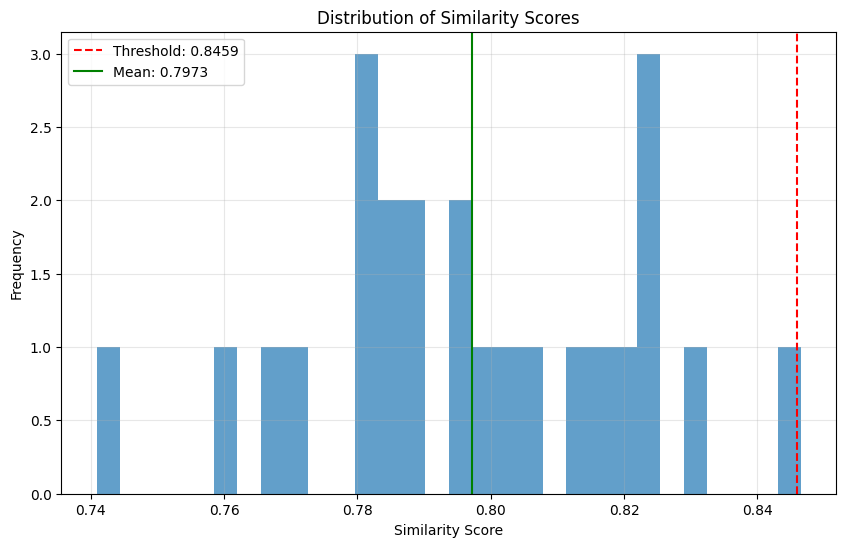

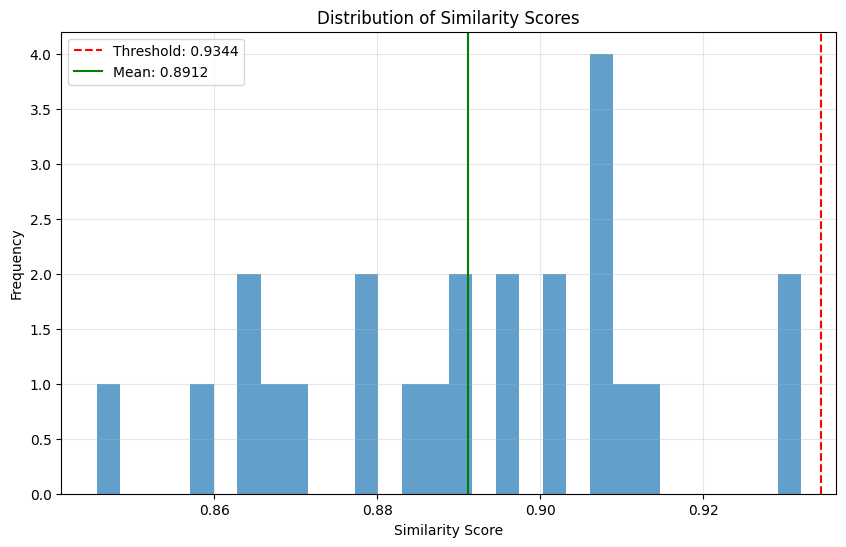

In [46]:
# OPTION 2 (IMPROVED BY CLAUDE)

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from time import perf_counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def analyze_similarity_distribution(final_chunks, query_text):
    """
    Analyze the distribution of similarity scores for a query.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        
    Returns:
        Tuple of (scores, normalized_scores, threshold)
    """
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Analyzing similarity distribution for query: {query_text}")
    
    # Embed the query
    inputs = tokenizer(query_text, padding=True, truncation=True, 
                      max_length=512, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        query_embedding = outputs.last_hidden_state[:, 0, :]
    
    # Normalize query embedding
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    
    # Get all embeddings
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # Compute similarity scores
    dot_scores = torch.matmul(query_embedding, all_embeddings_tensor.T)[0].cpu().numpy()
    
    # Analyze distribution
    mean_score = np.mean(dot_scores)
    std_score = np.std(dot_scores)
    min_score = np.min(dot_scores)
    max_score = np.max(dot_scores)
    
    # Calculate Z-scores for outlier detection
    z_scores = (dot_scores - mean_score) / std_score
    
    # Identify potential threshold
    # A common approach is mean + 2*std for outlier detection
    threshold = mean_score + 2 * std_score
    
    # Use MinMaxScaler to rescale scores to [0,1] range
    # This helps interpret relative relevance
    scaler = MinMaxScaler()
    normalized_scores = scaler.fit_transform(dot_scores.reshape(-1, 1)).flatten()
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(dot_scores, bins=30, alpha=0.7)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.axvline(mean_score, color='g', linestyle='-', label=f'Mean: {mean_score:.4f}')
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    print(f"Score Statistics:")
    print(f"  Mean: {mean_score:.4f}")
    print(f"  Std Dev: {std_score:.4f}")
    print(f"  Min: {min_score:.4f}")
    print(f"  Max: {max_score:.4f}")
    print(f"  Suggested Threshold: {threshold:.4f}")
    print(f"  Documents above threshold: {np.sum(dot_scores > threshold)}/{len(dot_scores)}")
    
    # Return scores for further analysis
    return dot_scores, normalized_scores, threshold


def search_similar_chunks(final_chunks, query_text, top_k=5, threshold=None, use_relative_scoring=True):
    """
    Search for chunks similar to a query using improved scoring mechanisms.
    
    Args:
        final_chunks: List of dictionaries containing text chunks and their embeddings
        query_text: The query text to search for
        top_k: Number of top results to return
        threshold: Optional cutoff value for scores
        use_relative_scoring: Whether to use relative (normalized) scoring
        
    Returns:
        Tuple of (indices, scores, results) for the top similar chunks
    """
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
    model = AutoModel.from_pretrained('allenai/specter2_base')
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Query: {query_text}")
    
    # 1. Embed the query
    start_time = perf_counter()
    inputs = tokenizer(query_text, padding=True, truncation=True, 
                      max_length=512, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        query_embedding = outputs.last_hidden_state[:, 0, :]
    
    # 2. Normalize query embedding
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    
    # 3. Get all chunk embeddings
    all_embeddings = np.array([chunk["embedding"] for chunk in final_chunks])
    all_embeddings_tensor = torch.tensor(all_embeddings).to(device)
    all_embeddings_tensor = all_embeddings_tensor / all_embeddings_tensor.norm(dim=1, keepdim=True)
    
    # 4. Compute similarity scores
    dot_scores = torch.matmul(query_embedding, all_embeddings_tensor.T)[0].cpu().numpy()
    
    # 5. Compute relative scores
    if use_relative_scoring:
        mean_score = np.mean(dot_scores)
        std_score = np.std(dot_scores)
        # Convert to Z-scores
        relative_scores = (dot_scores - mean_score) / std_score
        # Also compute min-max scaled scores for easier interpretation
        scaler = MinMaxScaler()
        scaled_scores = scaler.fit_transform(dot_scores.reshape(-1, 1)).flatten()
    
    # 6. Apply threshold if specified
    if threshold is not None:
        valid_indices = np.where(dot_scores >= threshold)[0]
        if len(valid_indices) == 0:
            print("No results above threshold")
            return [], [], []
        
        # Filter based on threshold
        filtered_scores = dot_scores[valid_indices]
        top_k = min(top_k, len(filtered_scores))
        
        # Get top-k among valid indices
        top_indices = np.argsort(-filtered_scores)[:top_k]
        top_indices = valid_indices[top_indices]
        top_scores = dot_scores[top_indices]
    else:
        # Get top-k without threshold
        top_indices = np.argsort(-dot_scores)[:top_k]
        top_scores = dot_scores[top_indices]
    
    # Get the actual chunks
    top_results = [final_chunks[idx] for idx in top_indices]
    
    end_time = perf_counter()
    print(f"Search completed in {end_time - start_time:.4f} seconds")
    
    # Print results with more context
    print("\nTop results:")
    for i, (idx, score) in enumerate(zip(top_indices, top_scores)):
        print(f"{i+1}. Raw Score: {score:.4f}")
        
        if use_relative_scoring:
            print(f"   Z-Score: {relative_scores[idx]:.4f}")
            print(f"   Normalized Score: {scaled_scores[idx]:.4f}")
            
        print(f"   Page: {top_results[i]['page_number']}")
        print(f"   Text: {top_results[i]['sentence_chunk'][:150]}...")
        print()
    
    return top_indices, top_scores, top_results


# Example usage
if __name__ == "__main__":
    # First analyze the distribution to determine a good threshold
    scores, norm_scores, suggested_threshold = analyze_similarity_distribution(
        final_chunks, "good foods for protein")
    
    # Then search with the threshold
    print("\n=== SEARCH WITH THRESHOLD ===")
    indices, scores, results = search_similar_chunks(
        final_chunks, 
        "good foods for protein",
        threshold=suggested_threshold,
        use_relative_scoring=True
    )
    
    # For comparison, run a more relevant query
    print("\n=== RELEVANT QUERY ANALYSIS ===")
    relevant_scores, relevant_norm, relevant_threshold = analyze_similarity_distribution(
        final_chunks, "heritage imaging techniques")

In [36]:
# 1. Define query
query = "good foods for protein"
print(f"Query: {query}")

# 2. Embed the query
# Note: it's important to embed your query with the SAME MODEL as embeddings
query_embedding = model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores
# with dot product (use cosine similarity if outputs of model aren't normalised)
from time import perf_counter as timer

start_time = timer
dot_scores = util.dot_score(a=query_embedding, b=final_embedded_chunks)[0]
end_time = timer

# 4. Get the top-k results (we keep top 5)
top_results_dot_product = torch.topk(dot_scores, 5)
top_results_dot_product

Query: good foods for protein


AttributeError: 'BertModel' object has no attribute 'encode'